In [1]:
# Python
import pandas as pd
from fbprophet import Prophet
import sklearn.metrics
import math

Importing plotly failed. Interactive plots will not work.


In [23]:
df = pd.read_csv("./data/synthetic_basic/Synthetic_Basic_1.csv")

In [14]:
df.head()

,Unnamed: 0,Power,POA,Tamb,Wind,Degradation_rate_per_yr,soiling
0,2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,-0.01436,1
1,2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,-0.01436,1
2,2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,-0.01436,1
3,2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,-0.01436,1
4,2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,-0.01436,1


### What I did

In [15]:
#If you wanna try date down to the minute
#df['Date'] = df['Unnamed: 0'].apply(lambda x: x[:-6])
df['Date'] = df['Unnamed: 0'].apply(lambda x: x.split(' ')[0])

In [18]:
df_by_day = df.groupby('Date', as_index=False).Power.mean()
df_by_day = df_by_day.rename(columns={'Date':'ds','Power':'y'})

In [19]:
df_by_day.head()

,ds,y
0,2015-01-01,306.836111
1,2015-01-02,308.401389
2,2015-01-03,310.086806
3,2015-01-04,311.900000
4,2015-01-05,313.829167


In [20]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=False, seasonality_mode='multiplicative')
m.fit(df_by_day)

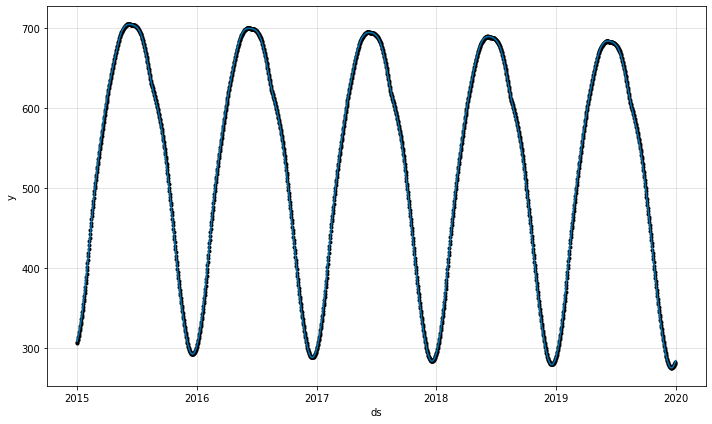

In [21]:
future = m.make_future_dataframe(1, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

/Users/antoine/ml/my_env/lib/python3.8/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/antoine/ml/my_env/lib/python3.8/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


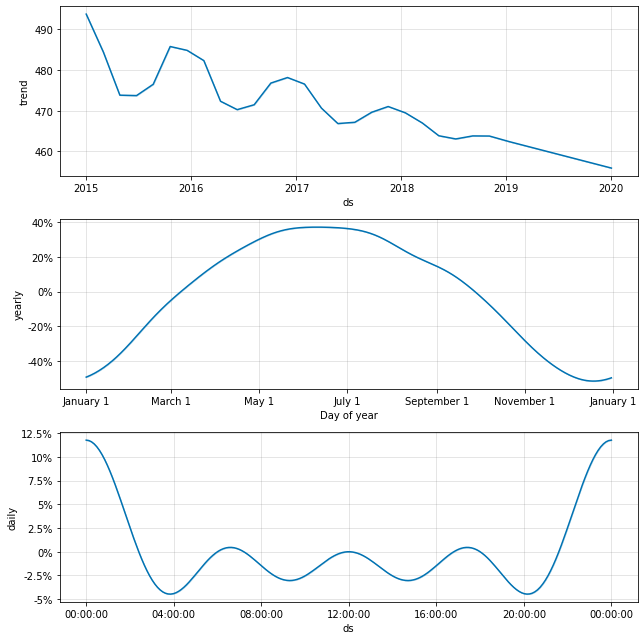

In [22]:
fig = m.plot_components(forecast)

### What Darren did

In [24]:
df = pd.read_csv("./data/synthetic_basic/Synthetic_Basic_1.csv")

df = df.rename(columns={'Unnamed: 0':'time'})
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.tz_localize(None)
time_df = df.set_index('time')

daily_df = time_df.resample('H').mean()
daily_df = daily_df.reset_index()

fb_df = daily_df[["time", "Power"]]
fb_df = fb_df.rename(columns={'time':'ds', 'Power':'y'})
fb_df["ds"] = fb_df["ds"].dt.tz_localize(None)

m = Prophet(yearly_seasonality = True, weekly_seasonality=False)
m.fit(fb_df)

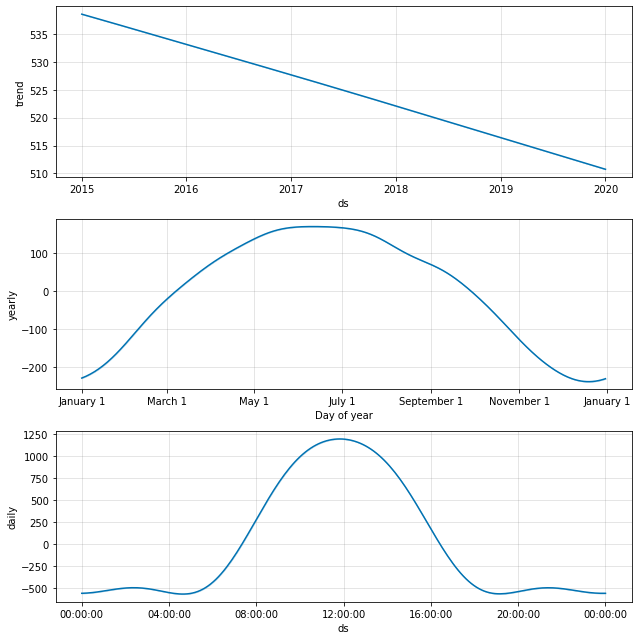

In [25]:
future = pd.date_range('2015-01-01', periods=daily_df.shape[0], freq='H')
future = pd.DataFrame(future)
future = future.rename(columns={0:'ds'})
forecast = m.predict(future)

fig2 = m.plot_components(forecast)

In [46]:
(forecast.iloc[0].trend - forecast.iloc[12409].trend)/forecast.iloc[0].trend

0.0142899419906278

### Loop to determine the RMSE of simple Prophet's treatment

In [113]:
df_weather_prediction = pd.DataFrame(columns=['actual_degradation',
                                        'predicted_degradation'])
for i in range(0,50):
    print("Processing file #"+str(i))
    df = pd.read_csv("./data/synthetic_weather/Synthetic_Weather_"+str(i)+".csv")

    df = df.rename(columns={'Unnamed: 0':'time'})
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.tz_localize(None)
    time_df = df.set_index('time')

    daily_df = time_df.resample('H').mean()
    daily_df = daily_df.reset_index()

    fb_df = daily_df[["time", "Power"]]
    fb_df = fb_df.rename(columns={'time':'ds', 'Power':'y'})
    fb_df["ds"] = fb_df["ds"].dt.tz_localize(None)

    m = Prophet(yearly_seasonality = True, weekly_seasonality=False)
    m.fit(fb_df)
    
    future = pd.date_range('2015-01-01', periods=daily_df.shape[0], freq='H')
    future = pd.DataFrame(future)
    future = future.rename(columns={0:'ds'})
    forecast = m.predict(future)
    
    #degradation computed using the trend at the point of the two first 1st of January
    #Not used for weather
    #predicted_degradation_1 = (forecast.iloc[0].trend - forecast.iloc[12409].trend)/forecast.iloc[0].trend
    
    #degradation computed by fitting the trend and extracting the slope
    model = np.polyfit([x/24/365 for x in range(0,len(forecast))],forecast.trend,1)
    predicted_degradation_2 = model[0]/model[1]
    
    df_weather_prediction.loc[i] = {"actual_degradation":df.iloc[0].Degradation_rate_per_yr,
                              #"predicted_degradation_1":predicted_degradation_1,
                              "predicted_degradation":predicted_degradation_2
                             }

Processing file #0
Processing file #1
Processing file #2
Processing file #3
Processing file #4
Processing file #5
Processing file #6
Processing file #7
Processing file #8
Processing file #9
Processing file #10
Processing file #11
Processing file #12
Processing file #13
Processing file #14
Processing file #15
Processing file #16
Processing file #17
Processing file #18
Processing file #19
Processing file #20
Processing file #21
Processing file #22
Processing file #23
Processing file #24
Processing file #25
Processing file #26
Processing file #27
Processing file #28
Processing file #29
Processing file #30
Processing file #31
Processing file #32
Processing file #33
Processing file #34
Processing file #35
Processing file #36
Processing file #37
Processing file #38
Processing file #39
Processing file #40
Processing file #41
Processing file #42
Processing file #43
Processing file #44
Processing file #45
Processing file #46
Processing file #47
Processing file #48
Processing file #49


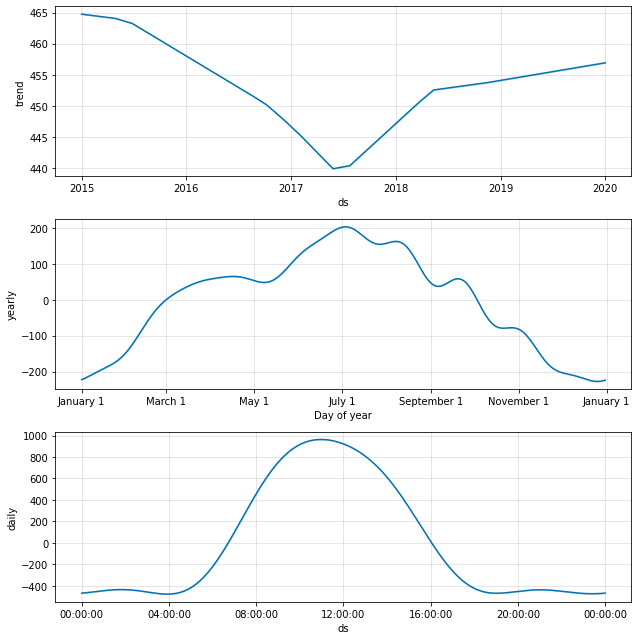

In [114]:
fig2 = m.plot_components(forecast)

In [95]:
df_soil_prediction.head()

,actual_degradation,predicted_degradation_1,predicted_degradation_2
0,-0.01073,0.056723,-0.006817
1,-0.01114,-0.041335,-0.005459
2,-0.01225,-0.004744,-0.015009
3,-0.01122,0.009973,-0.009499
4,-0.00278,-0.036285,-0.016708


In [115]:
df_weather_prediction.to_csv('Prophet predictions to weather data.csv')

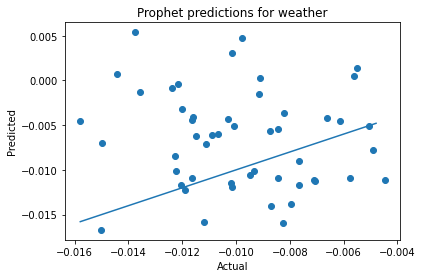

In [130]:
plt.figure()
ax = plt.axes()
plt.scatter(df_weather_prediction.actual_degradation,df_weather_prediction.predicted_degradation)
diagonal_line = np.arange(min(df_weather_prediction.actual_degradation),
          max(df_weather_prediction.actual_degradation),
         0.001)
ax.plot(diagonal_line, diagonal_line)
plt.title('Prophet predictions for weather')
plt.xlabel('Actual')
plt.ylabel('Predicted')
#plt.legend(['x=y line','Using two datapoints of the trend','Doing linear fit on the trend'])
plt.show()

In [131]:
mse = sklearn.metrics.mean_squared_error(df_weather_prediction.actual_degradation, df_weather_prediction.predicted_degradation)
math.sqrt(mse)

0.007099852242888722

In [107]:
df_basic = pd.read_csv("Prophet predictions to basic data.csv")

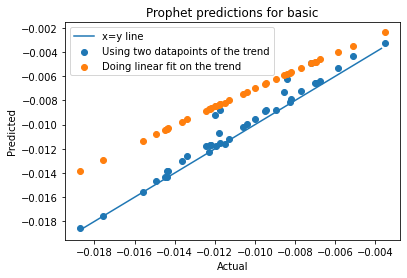

In [128]:
plt.figure()
ax = plt.axes()
plt.scatter(df_basic.actual_degradation,-1*df_basic.predicted_degradation_1)
plt.scatter(df_basic.actual_degradation,df_basic.predicted_degradation_2)
diagonal_line = np.arange(min(df_basic.actual_degradation),
          max(df_basic.actual_degradation),
         0.001)
ax.plot(diagonal_line, diagonal_line)
plt.title('Prophet predictions for basic')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(['x=y line','Using two datapoints of the trend','Doing linear fit on the trend'])
plt.show()

In [111]:
mse = sklearn.metrics.mean_squared_error(df_basic.actual_degradation, df_basic.predicted_degradation_2)
math. sqrt(mse)

0.003278117100606532

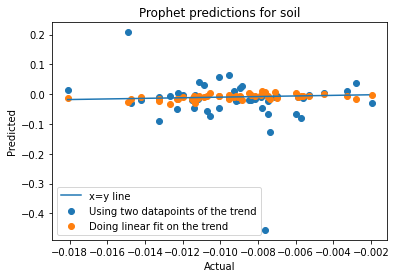

In [126]:
df_soil = pd.read_csv("Prophet predictions to soil data.csv")

plt.figure()
ax = plt.axes()
plt.scatter(df_soil.actual_degradation,-1*df_soil.predicted_degradation_1)
plt.scatter(df_soil.actual_degradation,df_soil.predicted_degradation_2)
diagonal_line = np.arange(min(df_soil.actual_degradation),
          max(df_soil.actual_degradation),
         0.001)
ax.plot(diagonal_line, diagonal_line)
plt.title('Prophet predictions for soil')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(['x=y line','Using two datapoints of the trend','Doing linear fit on the trend'])
plt.show()

In [129]:
mse = sklearn.metrics.mean_squared_error(df_soil.actual_degradation, df_soil.predicted_degradation_2)
math. sqrt(mse)

0.008262705075139128

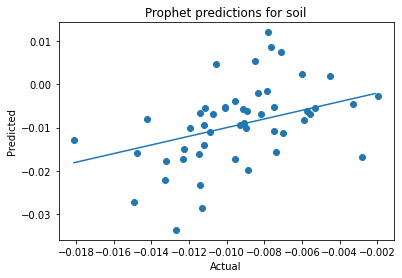

In [132]:
df_soil = pd.read_csv("Prophet predictions to soil data.csv")

plt.figure()
ax = plt.axes()
plt.scatter(df_soil.actual_degradation,df_soil.predicted_degradation_2)
diagonal_line = np.arange(min(df_soil.actual_degradation),
          max(df_soil.actual_degradation),
         0.001)
ax.plot(diagonal_line, diagonal_line)
plt.title('Prophet predictions for soil')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()